<a href="https://colab.research.google.com/github/dstephenhaynes/DTSA5010BBC/blob/main/DTSA5510_BBC_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <center>
<h1><center>BBC News Classification Kaggle Mini-Project</center></h1>
<h2><center>Unsupervised Algorithms in Machine Learning</center></h2>
<h3><center>
DTSA-5510

University of Colorado Boulder

D. Stephen Haynes
</center></h3>



##BBC News Classification
- This project will use a variety of Unsupervised Learning methods as a simulation of an entry in the Kaggle BBC News Classification Competition available here: https://www.kaggle.com/c/learn-ai-bbc/overview
- The code below will ingest the datasets available at the Kaggle site listed above, ingest the text from each article and then, using Unsupervised Learning methods:
  - Convert the texts into feature vectors
  - Train the model for matrix factorization
  - Predict the training and test dataset labels
  - Evaluate performance for both datasets
  - Tune hyperparameters to discover performance enhancement opportunities
  - Attempt to improve overall model performance through alternate feature extraction and ensemble methods
- Once the Unsupervised Learning methods have been evaluated, the datasets will be evaluated using a single Supervised Learning method. The results of these analyses will be compared to the Unsupervised Learning methods and discussed through narrative.

## Natural Language Processing (NLP)
- Natural Language Processing (NLP) is vital to evaluating any text-based dataset. "NLP is a branch of artificial intelligence that deals with analyzing, understanding, and generating the languages that humans use naturally in order to interface with computers in both written and spoken contexts using natural human languages instead of computer languages." [1] In the context of this project, NLP will assist with translating news article texts written in English into numeric representations of frequency within each grouping. NLP will also be used to eliminate insignificant words from each text to enhance the efficiency of vectorization encoding algorithms.

### The Dataset
- The dataset for this project is from the BBC News Classification project by Biljoy Bose and available at Kaggle: https://www.kaggle.com/c/learn-ai-bbc/overview
- The dataset is comprised of three, pre-split CSV files consisting of 1,490 training entries, 735 test entries, and a separate solution file that provides the proper category assignment for the 735 test entries.

In [323]:
# Import necessary libraries
import os
import re
import urllib.request
import zipfile
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from scipy.stats import mode

from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [324]:
train = pd.read_csv('https://raw.githubusercontent.com/dstephenhaynes/DTSA5010BBC/main/BBC%20News%20Train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/dstephenhaynes/DTSA5010BBC/main/BBC%20News%20Test.csv')
solution = pd.read_csv('https://raw.githubusercontent.com/dstephenhaynes/DTSA5010BBC/main/BBC%20News%20Sample%20Solution.csv')

# Data Cleaning

First, let's take a look at the details for each data file.

In [325]:
train.info()
print()
test.info()
print()
solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [326]:
train.head()

ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

In [327]:
test.head()

ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...

In [328]:
solution.head()

ArticleId       Category
0       1018          sport
1       1319           tech
2       1138       business
3        459  entertainment
4       1020       politics

We need to determine if there are any missing or otherwise troublesome entries in the data. The code below will:
- Determine if there are any Null values present
- Evaluate the datasets for document length
- Determine the most frequent words used for each category type
- Using the stopwords library, clear out insignificant words and punctuation
- Reevaluate the most frequent words to ensure all unncessary words have been eliminated

In [329]:
# Identify any Null values in the data
train.isnull().sum(), test.isnull().sum()

(ArticleId    0
 Text         0
 Category     0
 dtype: int64,
 ArticleId    0
 Text         0
 dtype: int64)

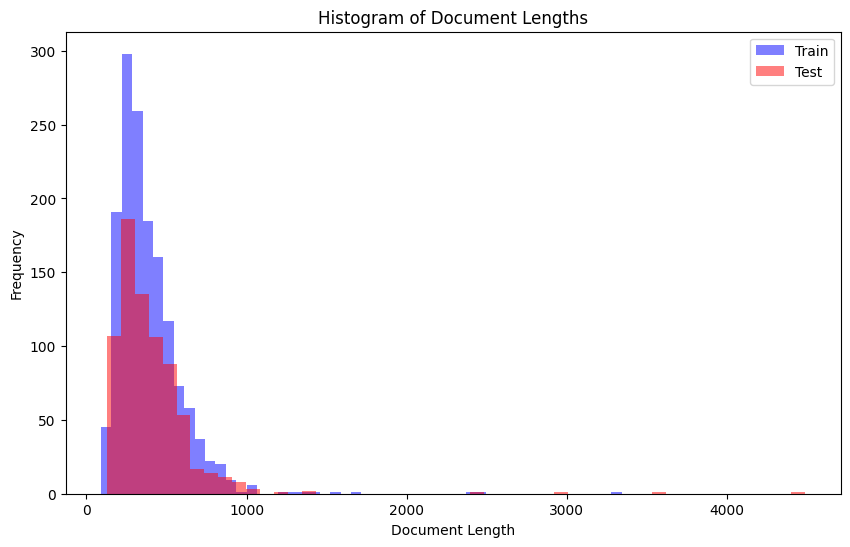

In [330]:
# Calculate document lengths
train['Doc_Length'] = train['Text'].apply(lambda x: len(x.split()))
test['Doc_Length'] = test['Text'].apply(lambda x: len(x.split()))

# Plot histograms of document lengths
plt.figure(figsize=(10, 6))
plt.hist(train['Doc_Length'], bins=50, alpha=0.5, color='blue', label='Train')
plt.hist(test['Doc_Length'], bins=50, alpha=0.5, color='red', label='Test')
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


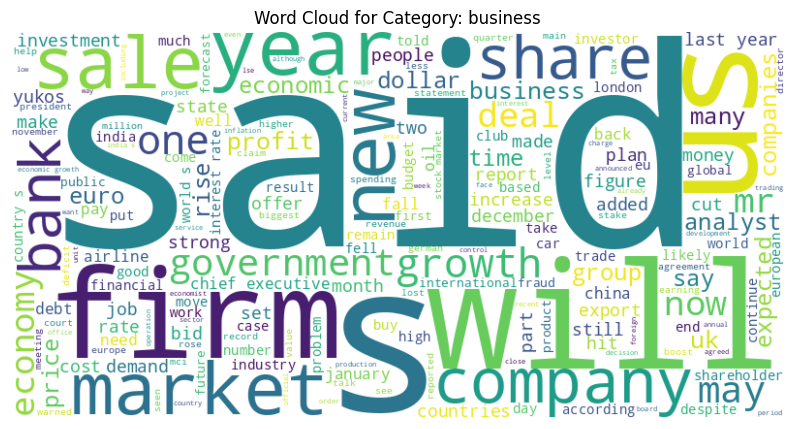

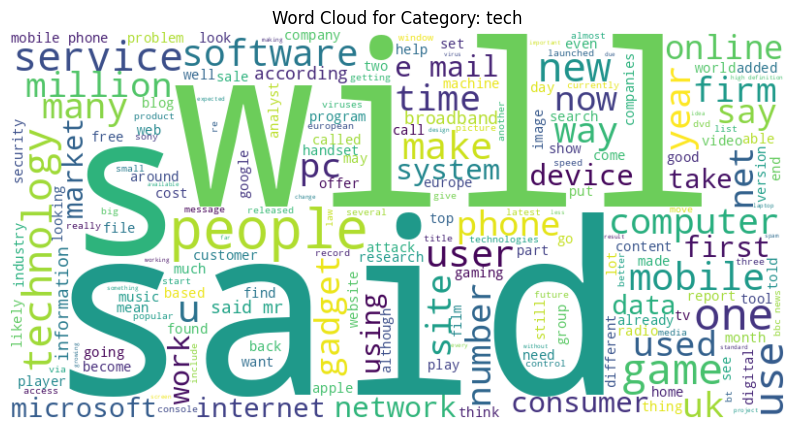

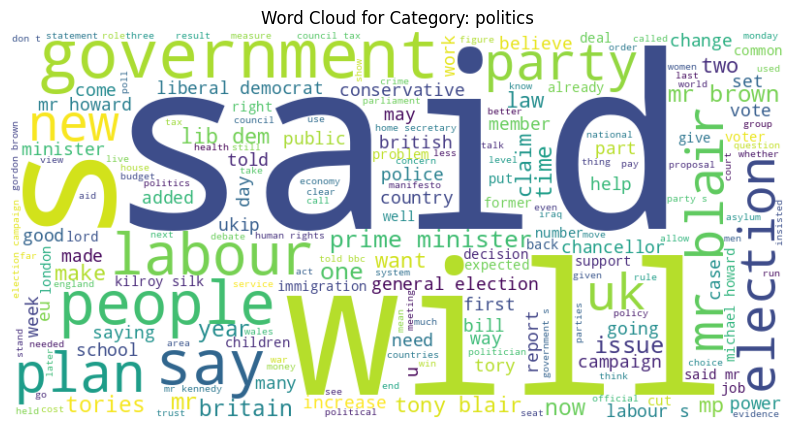

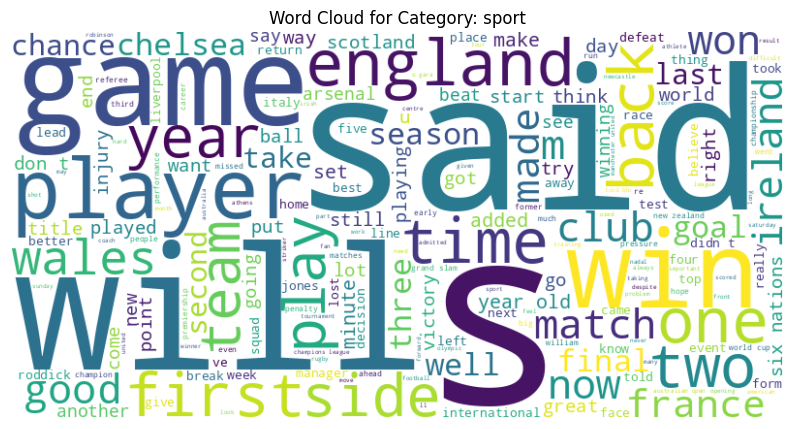

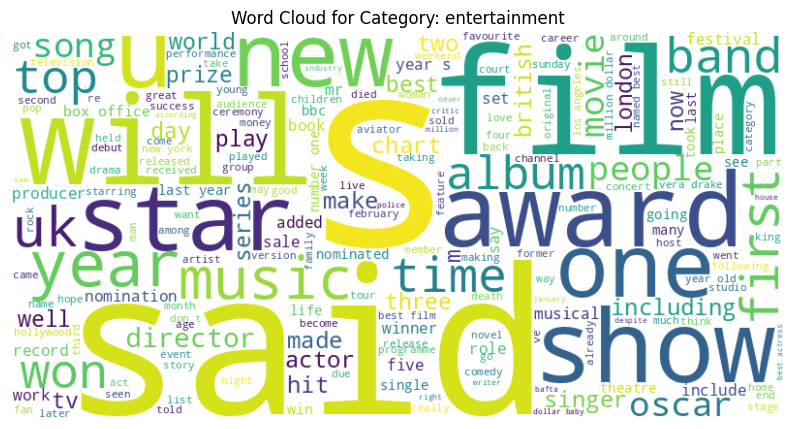

In [296]:
# Generate word clouds for each category
categories = train['Category'].unique()
for category in categories:
    text = ' '.join(train[train['Category'] == category]['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()


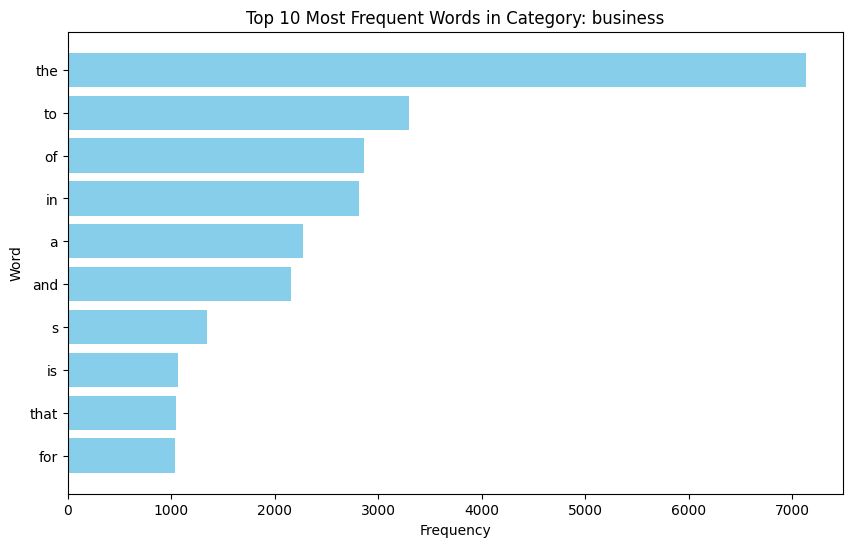

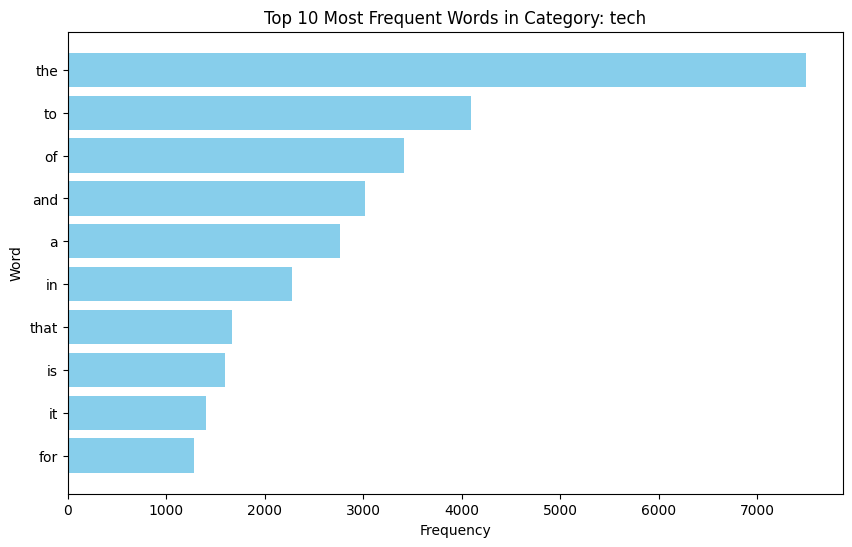

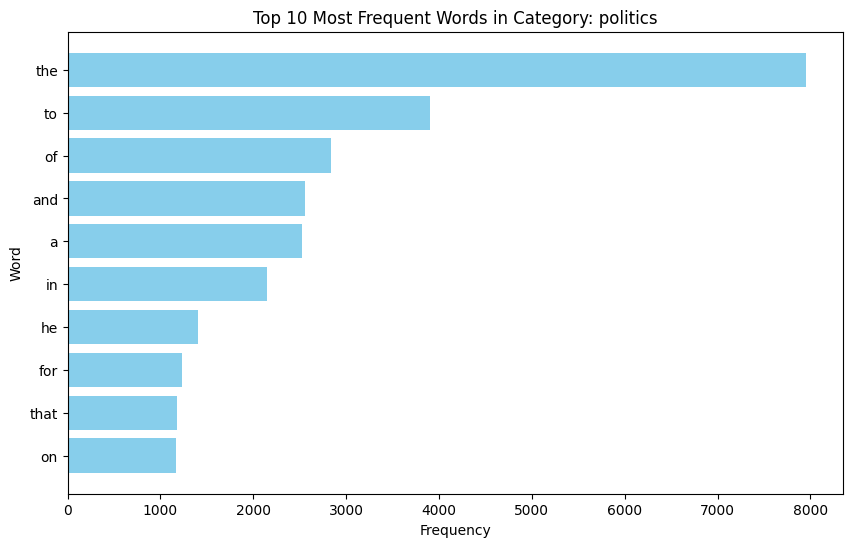

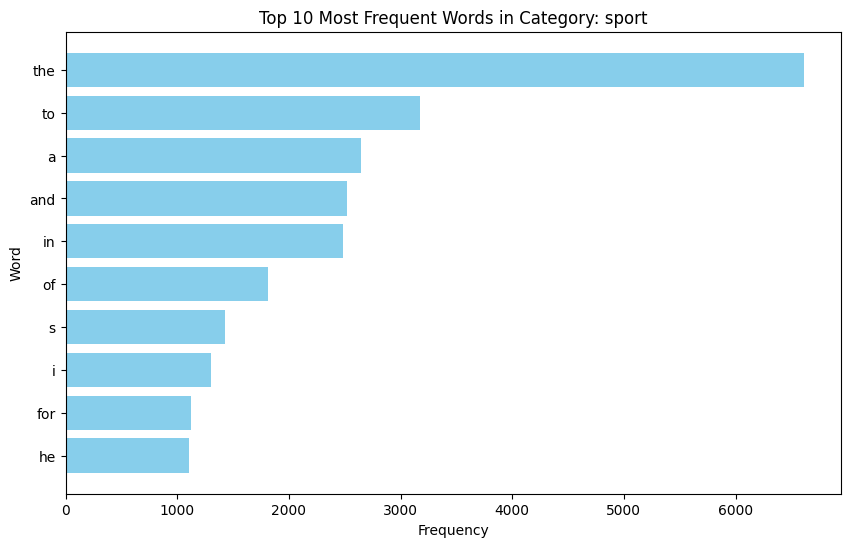

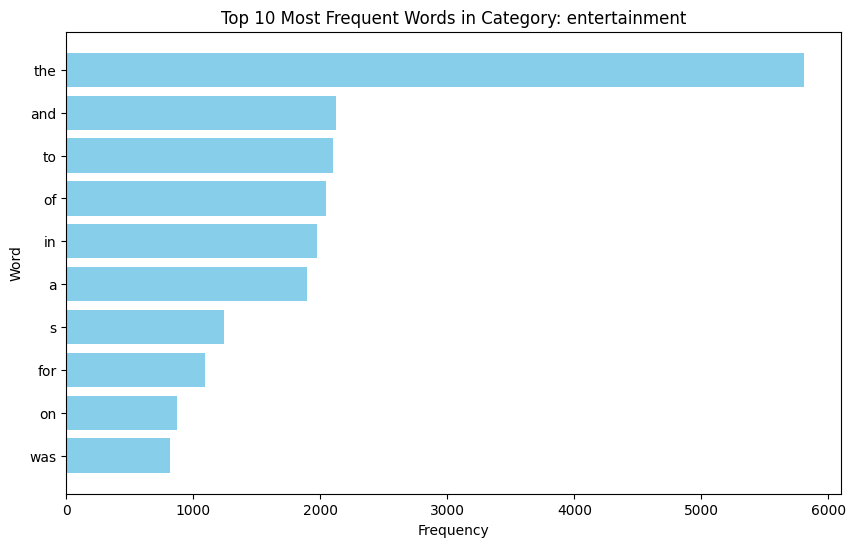

In [297]:
# Function to get the top n most common words in a text, excluding stop words and additional words
def get_top_words(text, n=10):
    words = text.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return dict(top_words)

# Function to plot the top n most frequent words for each category, excluding stop words and additional words
def plot_top_words_per_category(df, category_col, text_col, n=10):
    categories = df[category_col].unique()
    for category in categories:
        text = ' '.join(df[df[category_col] == category][text_col])
        top_words = get_top_words(text, n)
        plt.figure(figsize=(10, 6))
        plt.barh(list(top_words.keys()), list(top_words.values()), color='skyblue')
        plt.gca().invert_yaxis()  # Invert y-axis to have the most common words at the top
        plt.title(f'Top {n} Most Frequent Words in Category: {category}')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.show()

# Plot the top 10 most frequent words for each category in the training data, excluding stop words and additional words
plot_top_words_per_category(train, 'Category', 'Text', n=10)


The images above show that each category of news articles are dominated by frequently used, but insignificant words. Let's use a list of stopwords from the NLTK library to eliminate the words that don't contribute to category identification.

Note: Through a few iterations of running this code, additional words were noted and added to the 'additional_stop_words' list for elimination.

In [298]:
# Additional words to remove
additional_stop_words = ['said', 'mr', 'would', 'will', 'also', 'new']

# Function to clean text
def clean_text(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    stop_words.update(additional_stop_words)  # Add additional stop words
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    return ' '.join(text)

# Apply the cleaning function to the text data
train['CleanText'] = train['Text'].apply(clean_text)
test['CleanText'] = test['Text'].apply(clean_text)

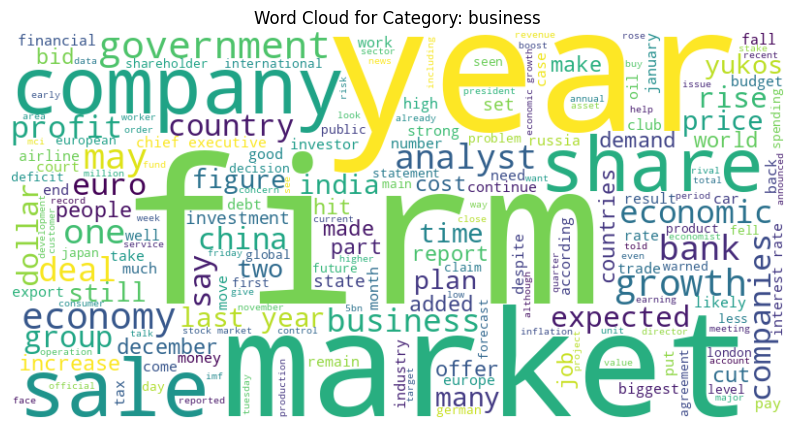

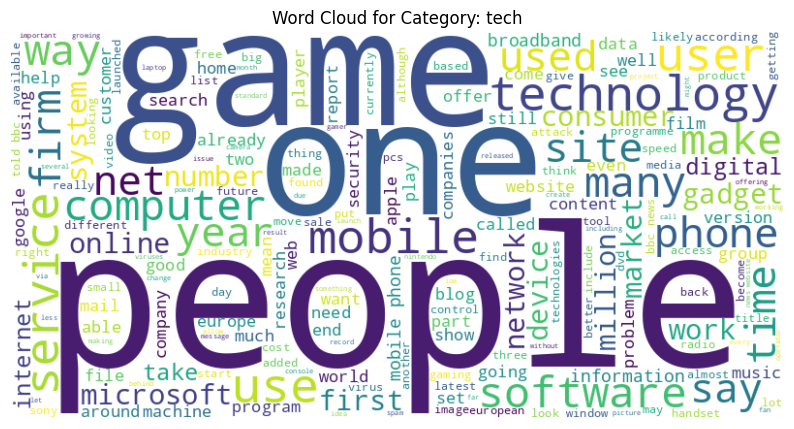

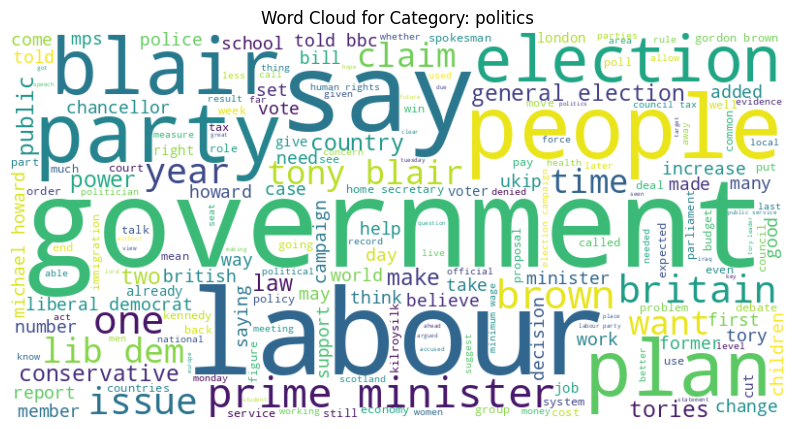

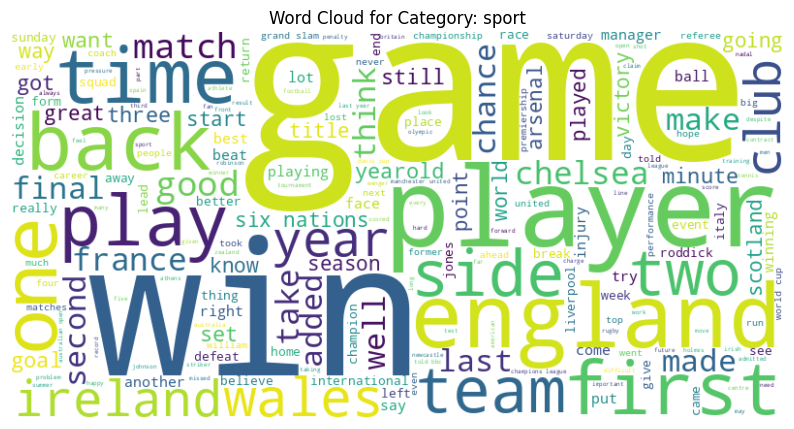

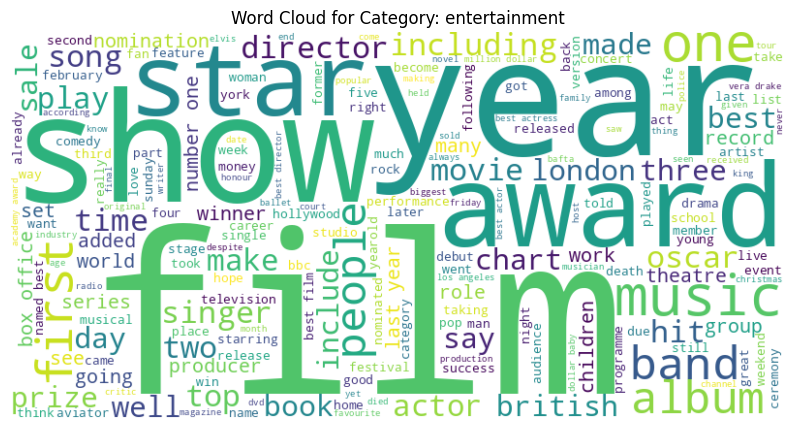

In [299]:
# Generate word clouds for each category after text cleaning
categories = train['Category'].unique()
for category in categories:
    text = ' '.join(train[train['Category'] == category]['CleanText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()


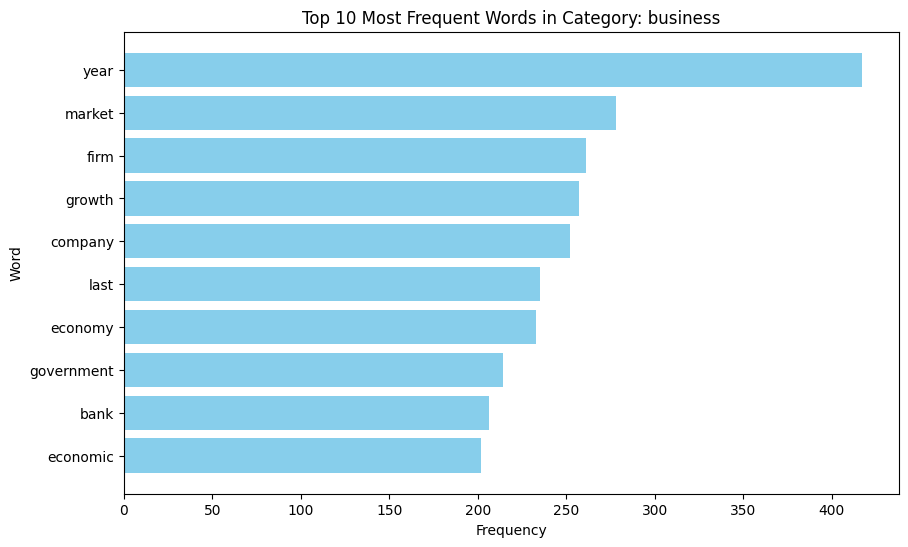

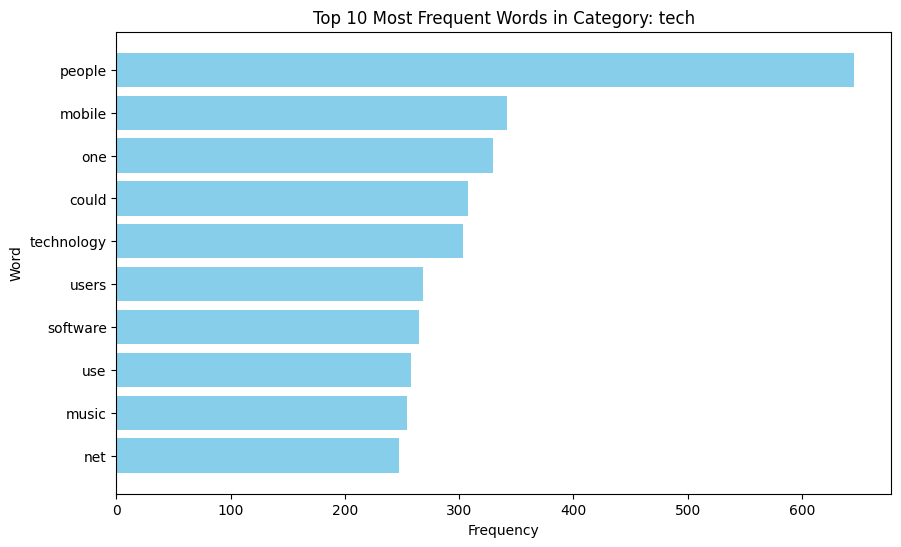

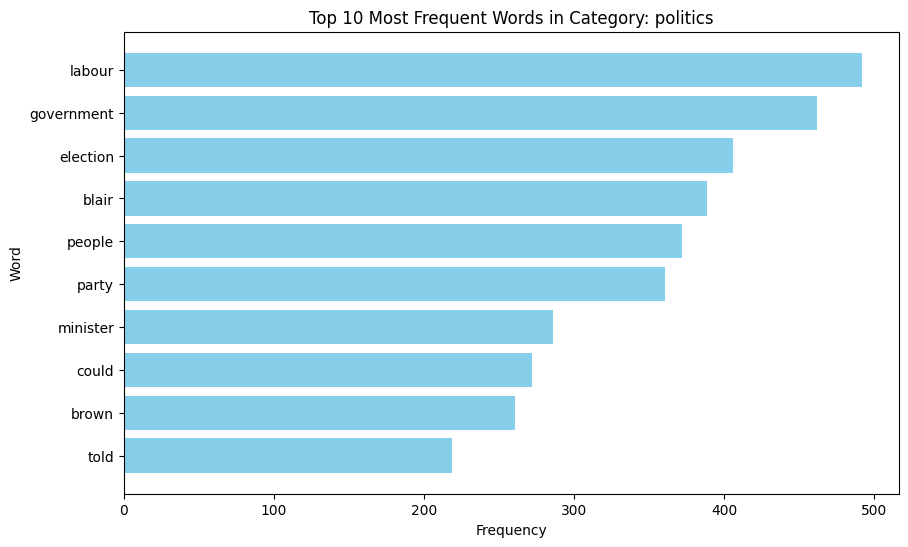

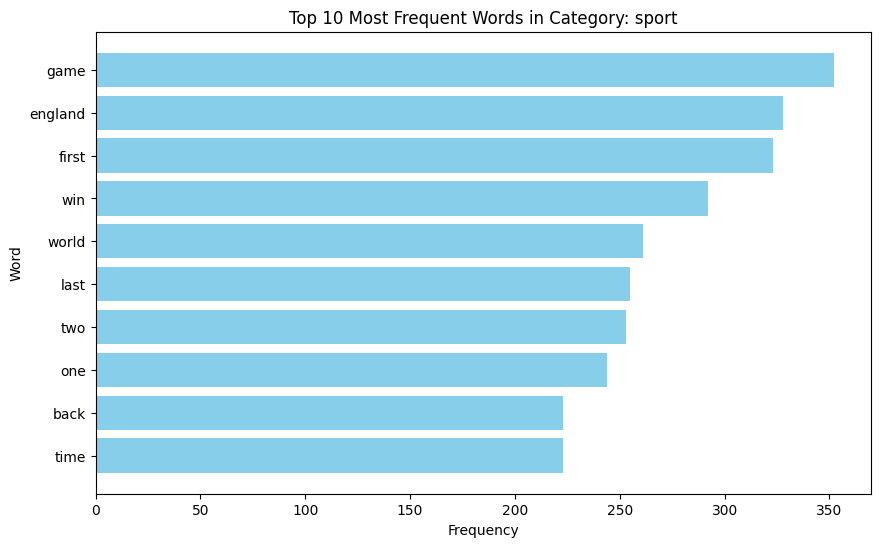

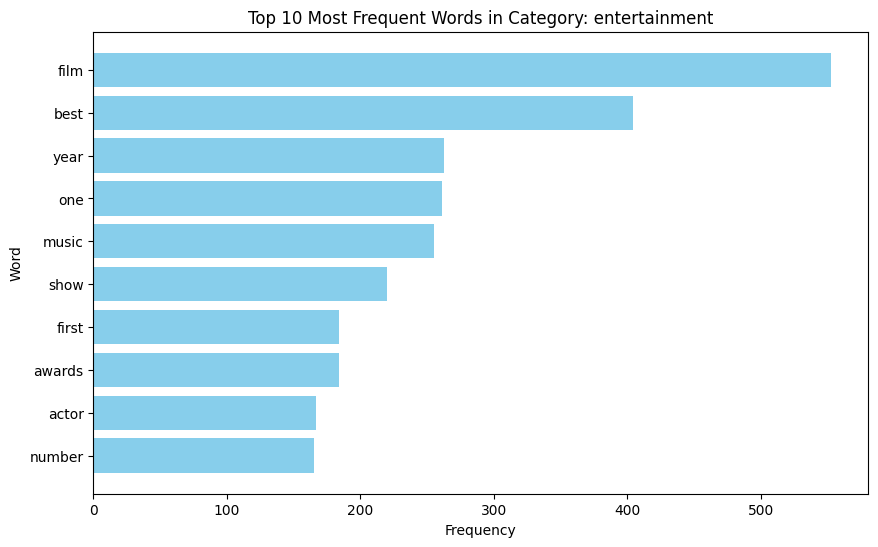

In [300]:
# Function to get the top n most common words in a text, excluding stop words and additional words
def get_top_words(text, n=10):
    words = text.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return dict(top_words)

# Function to plot the top n most frequent words for each category, excluding stop words and additional words
def plot_top_words_per_category(df, category_col, text_col, n=10):
    categories = df[category_col].unique()
    for category in categories:
        text = ' '.join(df[df[category_col] == category][text_col])
        top_words = get_top_words(text, n)
        plt.figure(figsize=(10, 6))
        plt.barh(list(top_words.keys()), list(top_words.values()), color='skyblue')
        plt.gca().invert_yaxis()  # Invert y-axis to have the most common words at the top
        plt.title(f'Top {n} Most Frequent Words in Category: {category}')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.show()

# Plot the top 10 most frequent words for each category in the training data, excluding stop words and additional words
plot_top_words_per_category(train, 'Category', 'CleanText', n=10)


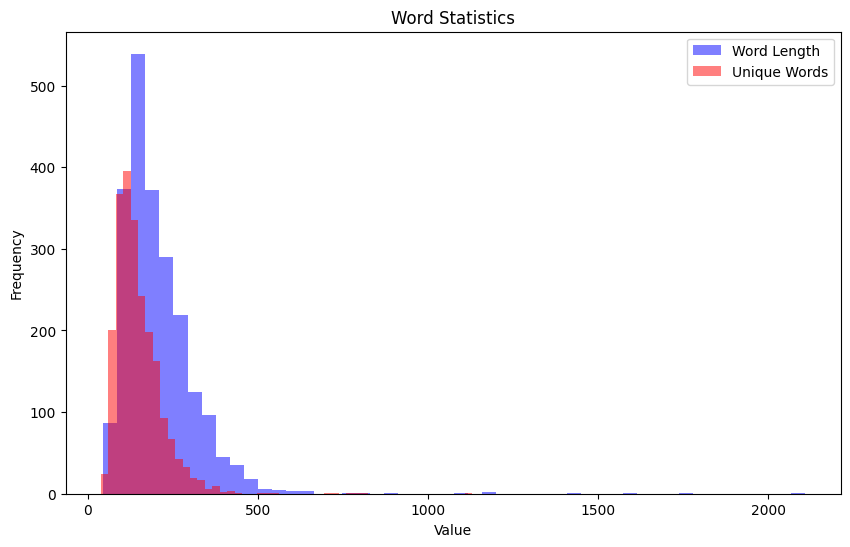

Shape of TF-IDF matrix: (2225, 30899)


In [301]:
# Combine train and test data for analysis
combined_data_clean = pd.concat([train['CleanText'], test['CleanText']], axis=0)

# Tokenize words
combined_data_tokenized = combined_data_clean.apply(lambda x: word_tokenize(x))

# Calculate word statistics
word_lengths = combined_data_tokenized.apply(lambda x: len(x))
unique_words = combined_data_tokenized.apply(lambda x: len(set(x)))

# Plot histograms of word statistics
plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=50, color='blue', alpha=0.5, label='Word Length')
plt.hist(unique_words, bins=50, color='red', alpha=0.5, label='Unique Words')
plt.title('Word Statistics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_data_clean)

# Display the shape of the TF-IDF matrix
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)

The word clouds and lists above appear to have words that better align with their category designation.

Let's make sure both datasets have 'CleanText' included.

In [302]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   1490 non-null   int64 
 1   Text        1490 non-null   object
 2   Category    1490 non-null   object
 3   Doc_Length  1490 non-null   int64 
 4   CleanText   1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   735 non-null    int64 
 1   Text        735 non-null    object
 2   Doc_Length  735 non-null    int64 
 3   CleanText   735 non-null    object
dtypes: int64(2), object(2)
memory usage: 23.1+ KB


# Data Modeling and Analysis
- Now that the texts have been thinned of their insignificant words, we can convert the text into feature vectors. The code below will process the text using TF-IDF, GloVe, and Word2Vec methods. Then, we'll use Truncated SVD Matrix Factorization for unsupervised categorization of the articles and evaluate an accuracy for each method. For this method to function, we'll need to convert the category labels into numeric values.

### Term Frequency-Inverse Document Frequency (TF-IDF):
- TF-IDF is a text data vectorization method that helps identify significant words belonging to a specific type of document. [2] TF-IDF measures the balance between how frequently a particular word appears in a text and how infrequently that word appears in all texts. This method creates a word set that aligns with specific documents, allowing algorithms to identify documents by the prevalence of those words.

### Global Vectors for Word Representation (GloVe):
- GloVe is a word embedding method that creates vector representations of words based on their co-occurance statistics from a large dataset. [3] GloVe focuses on aggregating global word-word co-occurance counts to construct the word vectors. This method helps evaluate the relationship of specific word groupings to a particular text set.

### Word Vectorization (Word2Vec):
  - Word2Vec takes the concept of simple word-to-integer mapping methods and adds a two-layer neural network to map words to vectors that are hundreds of dimensions in size. [4] This allows Word2Vec to capture the context of words within documents and then predict the context of a document based on the presence of those words.

### Unsupervised Model Training
- When training an unsupervised model for matrix factorization, the text features from the test dataset should not be part of the input matrix. Since unsupervised learning aims to discover structures of relationships within the data without using labeled information, it should learn those patterns solely from the training data to ensure that it generalizes well to unseen data. Including test data during training could lead to overfitting, reducing the model's ability to accurately predict outcomes.

In [303]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train['CleanText'])
X_test_tfidf = tfidf_vectorizer.transform(test['CleanText'])

# GloVe Embeddings
glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_file = 'glove.6B.zip'
glove_dir = 'glove.6B'

if not os.path.exists(glove_file):
    urllib.request.urlretrieve(glove_url, glove_file)

if not os.path.exists(glove_dir):
    with zipfile.ZipFile(glove_file, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

def load_glove_vectors(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_vectors = load_glove_vectors(os.path.join(glove_dir, 'glove.6B.100d.txt'))

def get_glove_embeddings(text, glove_vectors, embedding_dim=100):
    words = text.split()
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        embedding_vector = glove_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return np.mean(embedding_matrix, axis=0)

X_train_glove = np.array([get_glove_embeddings(text, glove_vectors) for text in train['CleanText']])
X_test_glove = np.array([get_glove_embeddings(text, glove_vectors) for text in test['CleanText']])

# Word2Vec Embeddings
train_sentences = [text.split() for text in train['CleanText']]
test_sentences = [text.split() for text in test['CleanText']]

w2v_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_embeddings(text, w2v_model, embedding_dim=100):
    words = text.split()
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    return np.mean(embedding_matrix, axis=0)

X_train_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in train['CleanText']])
X_test_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in test['CleanText']])


In [304]:
# Merge test data with solution to get the correct labels
test = test.merge(solution, on='ArticleId')

# Copy the Category Names to new column
train['Category_Name'] = train['Category']
test['Category_Name'] = test['Category']
solution['Category_Name'] = solution['Category']

# Map category labels to numerical values in train and test data
category_mapping = {cat: i for i, cat in enumerate(train['Category'].unique())}
train['Category'] = train['Category'].map(category_mapping)
test['Category'] = test['Category'].map(category_mapping)
solution['Category'] = solution['Category'].map(category_mapping)


In [305]:
# Define a function to perform SVD and evaluate accuracy
def svd_classification(X_train, y_train, X_test, y_test, n_components=5):
    svd_model = TruncatedSVD(n_components=n_components, random_state=42)
    W_train = svd_model.fit_transform(X_train)
    W_test = svd_model.transform(X_test)

    # Normalize W matrices
    W_train = normalize(W_train)
    W_test = normalize(W_test)

    # Get the index of the max component for classification
    y_train_pred = np.argmax(W_train, axis=1)
    y_test_pred = np.argmax(W_test, axis=1)

    # Map indices to categories
    categories = np.unique(y_train)
    y_train_labels = [categories[i] for i in y_train_pred]
    y_test_labels = [categories[i] for i in y_test_pred]

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_test_labels)
    return accuracy

# Define a function to perform logistic regression and evaluate accuracy
def logistic_regression_classification(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Evaluate using TF-IDF
accuracy_tfidf_svd = svd_classification(X_train_tfidf, train['Category'], X_test_tfidf, test['Category'])
print(f'TF-IDF SVD Accuracy: {accuracy_tfidf_svd * 100:.2f}%')

accuracy_tfidf_lr = logistic_regression_classification(X_train_tfidf, train['Category'], X_test_tfidf, test['Category'])
print(f'TF-IDF Logistic Regression Accuracy: {accuracy_tfidf_lr * 100:.2f}%')

# Evaluate using GloVe
accuracy_glove_svd = svd_classification(X_train_glove, train['Category'], X_test_glove, test['Category'])
print(f'GloVe SVD Accuracy: {accuracy_glove_svd * 100:.2f}%')

accuracy_glove_lr = logistic_regression_classification(X_train_glove, train['Category'], X_test_glove, test['Category'])
print(f'GloVe Logistic Regression Accuracy: {accuracy_glove_lr * 100:.2f}%')

# Evaluate using Word2Vec
accuracy_w2v_svd = svd_classification(X_train_w2v, train['Category'], X_test_w2v, test['Category'])
print(f'Word2Vec SVD Accuracy: {accuracy_w2v_svd * 100:.2f}%')

accuracy_w2v_lr = logistic_regression_classification(X_train_w2v, train['Category'], X_test_w2v, test['Category'])
print(f'Word2Vec Logistic Regression Accuracy: {accuracy_w2v_lr * 100:.2f}%')


TF-IDF SVD Accuracy: 17.14%
TF-IDF Logistic Regression Accuracy: 19.18%
GloVe SVD Accuracy: 20.00%
GloVe Logistic Regression Accuracy: 19.05%
Word2Vec SVD Accuracy: 20.00%
Word2Vec Logistic Regression Accuracy: 19.05%


It looks like Word2Vec has slightly better initial accuracy, so we'll continue with that method.
First, let's see what has been done to our datasets.

In [306]:
train.head()

ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...         0   
1        154  german business confidence slides german busin...         0   
2       1101  bbc poll indicates economic gloom citizens in ...         0   
3       1976  lifestyle  governs mobile choice  faster  bett...         1   
4        917  enron bosses in $168m payout eighteen former e...         0   

   Doc_Length                                          CleanText Category_Name  
0         301  worldcom boss launches defence lawyers defendi...      business  
1         325  german business confidence slides german busin...      business  
2         514  bbc poll indicates economic gloom citizens maj...      business  
3         634  lifestyle governs mobile choice faster better ...          tech  
4         355  enron bosses 168m payout eighteen former enron...      business

In [307]:
test.head()

ArticleId                                               Text  Doc_Length  \
0       1018  qpr keeper day heads for preston queens park r...         156   
1       1319  software watching while you work software that...         435   
2       1138  d arcy injury adds to ireland woe gordon d arc...         237   
3        459  india s reliance family feud heats up the ongo...         309   
4       1020  boro suffer morrison injury blow middlesbrough...         135   

                                           CleanText  Category  Category_Name  
0  qpr keeper day heads preston queens park range...         3          sport  
1  software watching work software monitor every ...         1           tech  
2  arcy injury adds ireland woe gordon arcy ruled...         0       business  
3  india reliance family feud heats ongoing publi...         4  entertainment  
4  boro suffer morrison injury blow middlesbrough...         2       politics

In [308]:
solution.head()

ArticleId  Category  Category_Name
0       1018         3          sport
1       1319         1           tech
2       1138         0       business
3        459         4  entertainment
4       1020         2       politics

To build a model using matrix factorization methods with Word2Vec embeddings, we can use Truncated SVD for dimensionality reduction. After transforming the data, we can use KMeans clustering to predict the labels for the training and test data.

In [309]:
# Prepare the sentences for Word2Vec
train_sentences = [text.split() for text in train['CleanText']]
test_sentences = [text.split() for text in test['CleanText']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_embeddings(text, w2v_model, embedding_dim=100):
    words = text.split()
    embedding_matrix = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    return np.mean(embedding_matrix, axis=0)

# Generate embeddings for train and test data
X_train_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in train['CleanText']])
X_test_w2v = np.array([get_w2v_embeddings(text, w2v_model) for text in test['CleanText']])

# Apply Truncated SVD
n_components = 5  # Static hyperparameter
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
W_train = svd_model.fit_transform(X_train_w2v)
W_test = svd_model.transform(X_test_w2v)

# Normalize the SVD-transformed data
W_train = normalize(W_train)
W_test = normalize(W_test)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)  # Assuming 5 categories as clusters
kmeans.fit(W_train)

# Predict the labels for train and test data
train_labels_pred = kmeans.predict(W_train)
test_labels_pred = kmeans.predict(W_test)

# Map predicted clusters to actual categories using majority voting
def map_clusters_to_labels(pred_labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(pred_labels):
        mask = (pred_labels == cluster)
        true_label_mode = mode(true_labels[mask])[0]
        label_mapping[cluster] = true_label_mode
    return np.array([label_mapping[label] for label in pred_labels])

# Map the clusters to the actual categories
train_labels_mapped = map_clusters_to_labels(train_labels_pred, train['Category'])
test_labels_mapped = map_clusters_to_labels(test_labels_pred, test['Category'])

# Evaluate the accuracy
train_accuracy = accuracy_score(train['Category'], train_labels_mapped)
test_accuracy = accuracy_score(test['Category'], test_labels_mapped)

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Train Accuracy: 48.79%
Test Accuracy: 24.22%


In [310]:
# Calculate accuracy
train_accuracy = accuracy_score(train['Category'], train_labels_mapped)
test_accuracy = accuracy_score(test['Category'], test_labels_mapped)

# Confusion matrix
train_cm = confusion_matrix(train['Category'], train_labels_mapped, labels=train['Category'].unique())
test_cm = confusion_matrix(test['Category'], test_labels_mapped, labels=test['Category'].unique())

# Classification report
train_report = classification_report(train['Category'], train_labels_mapped)
test_report = classification_report(test['Category'], test_labels_mapped)

print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.2f}")
print("Confusion Matrix:")
print(train_cm)
print("Classification Report:")
print(train_report)

print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.2f}")
print("Confusion Matrix:")
print(test_cm)
print("Classification Report:")
print(test_report)


Training Set Performance:
Accuracy: 0.49
Confusion Matrix:
[[  0  83  26 227   0]
 [  0 190   8  63   0]
 [  0  27 235  12   0]
 [  0  34  10 302   0]
 [  0  33  11 229   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       336
           1       0.52      0.73      0.61       261
           2       0.81      0.86      0.83       274
           3       0.36      0.87      0.51       346
           4       0.00      0.00      0.00       273

    accuracy                           0.49      1490
   macro avg       0.34      0.49      0.39      1490
weighted avg       0.32      0.49      0.38      1490


Test Set Performance:
Accuracy: 0.24
Confusion Matrix:
[[63  8 24 52  0]
 [47 13 28 59  0]
 [47 12 37 51  0]
 [42  8 32 65  0]
 [49  9 33 56  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.25      0.25       147
           1       0.26      0.09 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

The accuracy for the training set is at 50% while the test set accuracy is quite poor between 20% and 25%.

Let's adjust some of the parameters to see if we can achieve better performance.

In [311]:
# Define the pipeline
pipeline = Pipeline([
    ('svd', TruncatedSVD(random_state=42)),
    ('kmeans', KMeans(random_state=42))
])

# Define parameter grid
param_grid = {
    'svd__n_components': [2, 5, 10, 20, 50],
    'kmeans__n_clusters': [3, 5, 7, 10, 15]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_w2v, train['Category'])

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best Parameters: {'kmeans__n_clusters': 3, 'svd__n_components': 10}
Best Score: 0.2530201342281879


These alternate parameter values didn't seem to help.

Instead, we'll try three Ensemble Methods enhance performance.

In [312]:
# Define the individual classifiers
classifier1 = LogisticRegression(max_iter=1000, random_state=42)
classifier2 = RandomForestClassifier(random_state=42)
classifier3 = KNeighborsClassifier()

# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('logreg', classifier1),
    ('rf', classifier2),
    ('knn', classifier3)
], voting='hard')

# Evaluate the ensemble model using cross-validation
ensemble_scores = cross_val_score(ensemble_model, X_train_w2v, train['Category'], cv=5, scoring='accuracy')

print("Ensemble Model Cross-Validation Scores:", ensemble_scores)
print("Ensemble Model Mean Accuracy:", ensemble_scores.mean())


Ensemble Model Cross-Validation Scores: [0.79530201 0.80536913 0.80201342 0.86912752 0.83557047]
Ensemble Model Mean Accuracy: 0.8214765100671141


Training Set Performance:
Accuracy: 0.90


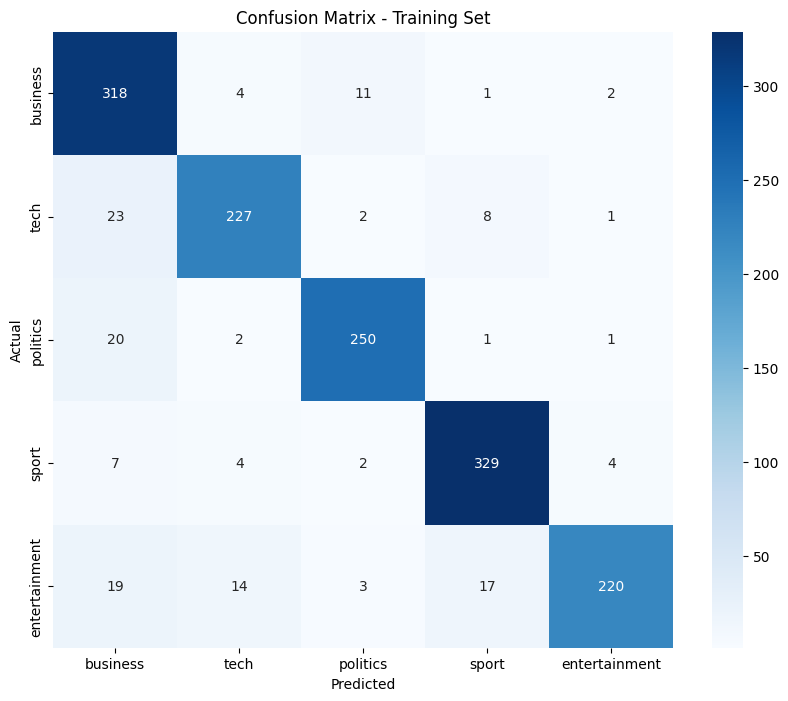

In [313]:
# Fit ensemble model on the training data
ensemble_model.fit(X_train_w2v, train['Category'])

# Predictions on training data
train_predictions = ensemble_model.predict(X_train_w2v)

# Calculate accuracy on training data
train_accuracy = accuracy_score(train['Category'], train_predictions)

# Confusion matrix for training data
train_cm = confusion_matrix(train['Category'], train_predictions, labels=train['Category'].unique())

# Print performance metrics
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train['Category_Name'].unique(), yticklabels=train['Category_Name'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Set')
plt.show()


In [314]:
# Evaluate the ensemble model using cross-validation on test data
ensemble_cv_scores = cross_val_score(ensemble_model, X_test_w2v, test['Category'], cv=5, scoring='accuracy')

print("Ensemble Model Cross-Validation Scores (Test Data):", ensemble_cv_scores)
print("Ensemble Model Mean Accuracy (Test Data):", ensemble_cv_scores.mean())


Ensemble Model Cross-Validation Scores (Test Data): [0.20408163 0.23809524 0.19047619 0.13605442 0.2244898 ]
Ensemble Model Mean Accuracy (Test Data): 0.19863945578231296



Test Set Performance:
Accuracy: 0.19


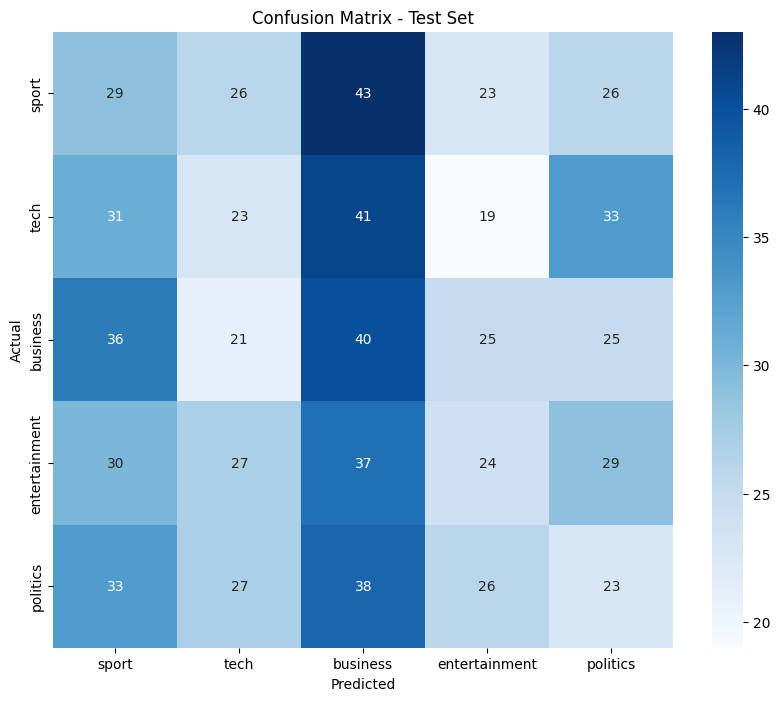

In [315]:
# Predictions on test data
test_predictions = ensemble_model.predict(X_test_w2v)

# Calculate accuracy on test data
test_accuracy = accuracy_score(test['Category'], test_predictions)

# Confusion matrix for test data
test_cm = confusion_matrix(test['Category'], test_predictions, labels=test['Category'].unique())

# Print performance metrics
print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test['Category_Name'].unique(), yticklabels=test['Category_Name'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()


Even with Ensemble Methods, we're not seeing improved performance on the test dataset.

Let's adjust our feature engineering approach and see if things improve, starting with TF-IDF vectorization.

In [316]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features as needed

# Fit and transform the test data
X_test_tfidf = tfidf_vectorizer.fit_transform(test['CleanText'])

# Convert to dense array
X_test_tfidf = X_test_tfidf.toarray()


Training Set Performance with TF-IDF Features:
Accuracy: 1.00


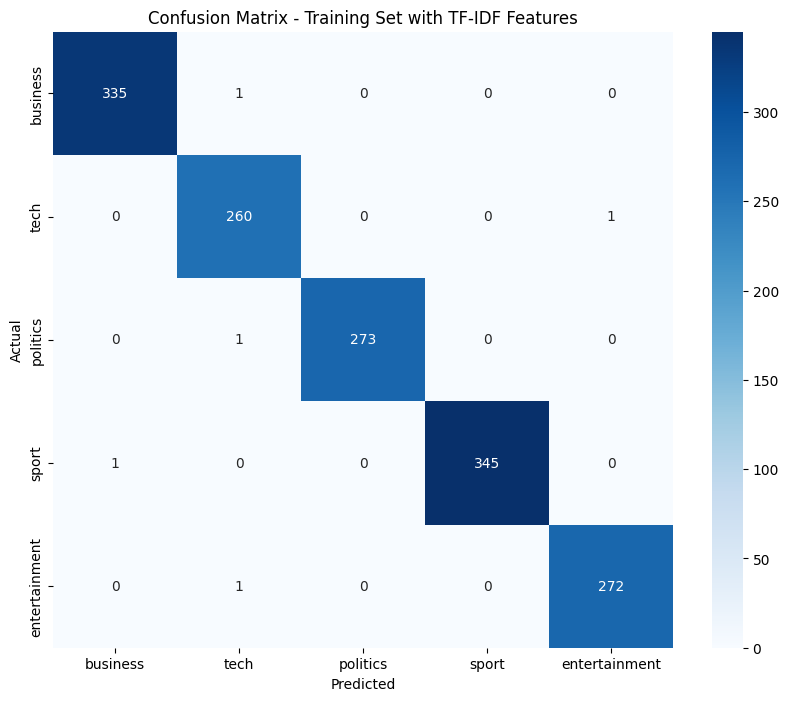

In [317]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features as needed

# Fit and transform the test data
X_test_tfidf = tfidf_vectorizer.fit_transform(test['CleanText'])

# Convert to dense array
X_test_tfidf = X_test_tfidf.toarray()

# Define the individual classifiers
classifier1 = LogisticRegression(max_iter=1000, random_state=42)
classifier2 = RandomForestClassifier(random_state=42)
classifier3 = KNeighborsClassifier()

# Define the ensemble model
ensemble_model_tfidf = VotingClassifier(estimators=[
    ('logreg', classifier1),
    ('rf', classifier2),
    ('knn', classifier3)
], voting='hard')

# Fit ensemble model on the training data with TF-IDF features
ensemble_model_tfidf.fit(X_train_tfidf, train['Category'])

# Predictions on training data
train_predictions_tfidf = ensemble_model_tfidf.predict(X_train_tfidf)

# Calculate accuracy on training data
train_accuracy_tfidf = accuracy_score(train['Category'], train_predictions_tfidf)

# Confusion matrix for training data
train_cm_tfidf = confusion_matrix(train['Category'], train_predictions_tfidf, labels=train['Category'].unique())

# Print performance metrics
print("Training Set Performance with TF-IDF Features:")
print(f"Accuracy: {train_accuracy_tfidf:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=train['Category_Name'].unique(), yticklabels=train['Category_Name'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Set with TF-IDF Features')
plt.show()


In [318]:
# Initialize TF-IDF vectorizer with the same number of features as Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the test data
X_test_tfidf = tfidf_vectorizer.fit_transform(test['CleanText'])

# Convert to dense array
X_test_tfidf = X_test_tfidf.toarray()



Test Set Performance with TF-IDF Features:
Accuracy: 0.21


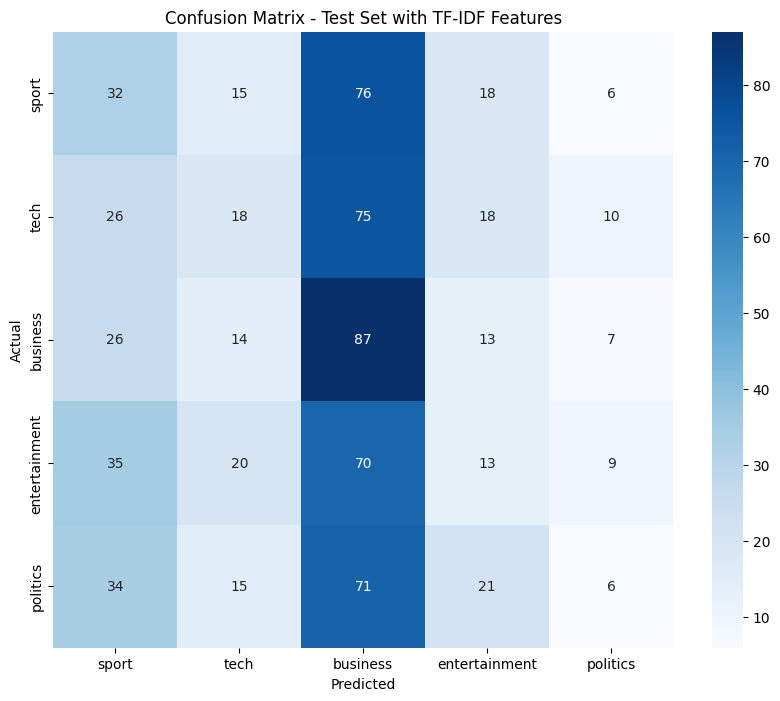

In [319]:
# Predictions on test data
test_predictions_tfidf = ensemble_model_tfidf.predict(X_test_tfidf)

# Calculate accuracy on test data
test_accuracy_tfidf = accuracy_score(test['Category'], test_predictions_tfidf)

# Confusion matrix for test data
test_cm_tfidf = confusion_matrix(test['Category'], test_predictions_tfidf, labels=test['Category'].unique())

# Print performance metrics
print("\nTest Set Performance with TF-IDF Features:")
print(f"Accuracy: {test_accuracy_tfidf:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=test['Category_Name'].unique(), yticklabels=test['Category_Name'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set with TF-IDF Features')
plt.show()


Somehow, we've achieved a near 100% accuracy with the training dataset. This likely means we're overfitting with the TF-IDF approach. However, we're still stuck at nearly 20% accuracy with the test dataset.
Now, we'll try a Support Vector Machine (SVM) classifier as a supervised learning algorithm approach.

Training Set Performance with SVM Classifier:
Accuracy: 1.00


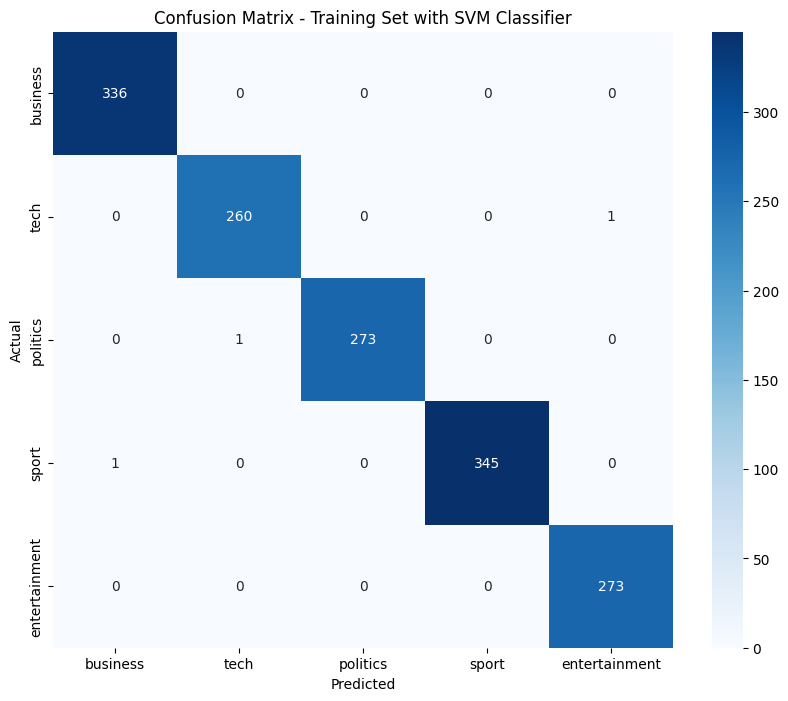

In [320]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Fit SVM classifier on the TF-IDF features
svm_classifier.fit(X_train_tfidf, train['Category'])

# Predictions on training data
train_predictions_svm = svm_classifier.predict(X_train_tfidf)

# Calculate accuracy on training data
train_accuracy_svm = accuracy_score(train['Category'], train_predictions_svm)

# Confusion matrix for training data
train_cm_svm = confusion_matrix(train['Category'], train_predictions_svm, labels=train['Category'].unique())

# Print performance metrics
print("Training Set Performance with SVM Classifier:")
print(f"Accuracy: {train_accuracy_svm:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=train['Category_Name'].unique(), yticklabels=train['Category_Name'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Set with SVM Classifier')
plt.show()



Test Set Performance with SVM Classifier:
Accuracy: 0.20


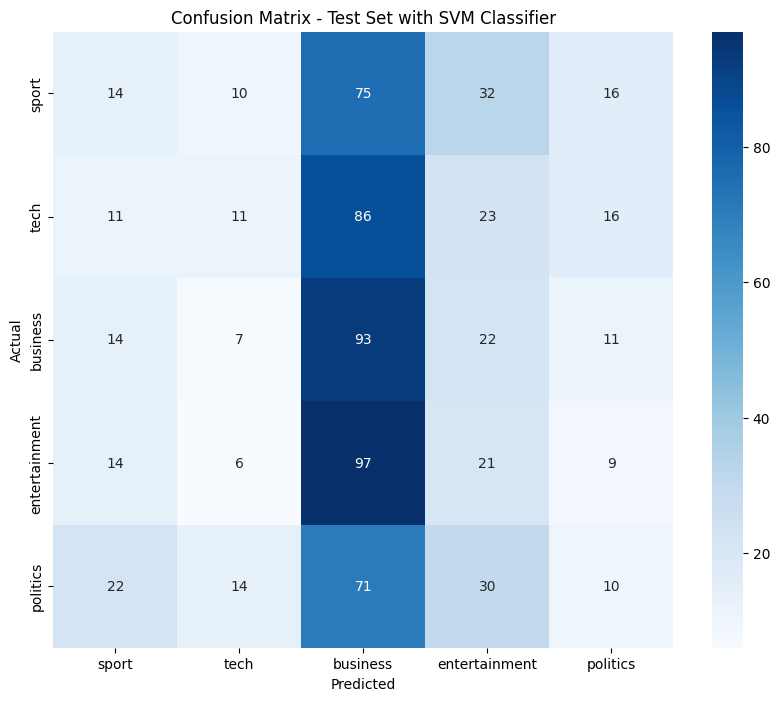

In [321]:
# Predictions on test data
test_predictions_svm = svm_classifier.predict(X_test_tfidf)

# Calculate accuracy on test data
test_accuracy_svm = accuracy_score(test['Category'], test_predictions_svm)

# Confusion matrix for test data
test_cm_svm = confusion_matrix(test['Category'], test_predictions_svm, labels=test['Category'].unique())

# Print performance metrics
print("\nTest Set Performance with SVM Classifier:")
print(f"Accuracy: {test_accuracy_svm:.2f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=test['Category_Name'].unique(), yticklabels=test['Category_Name'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set with SVM Classifier')
plt.show()


Even a Supervised Learning method, like SVM, produces similar accuracy results on the test dataset.
We'll try one last adjustment to the modeling method. We'll reduce the size of the training data and review accuracy for the TF-IDF and SVM methods.

In [322]:
# Proportions of labeled data
labeled_data_proportions = [0.1, 0.2, 0.5]

# Results storage
results = {}

# Iterate over different proportions of labeled data
for proportion in labeled_data_proportions:
    # Split the original labeled data into train and validation sets
    train_data, _, train_labels, _ = train_test_split(train['CleanText'], train['Category'],
                                                      train_size=proportion, stratify=train['Category'],
                                                      random_state=42)

    # Transform the text data to TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf_vectorizer.fit_transform(train_data)
    X_test_tfidf = tfidf_vectorizer.transform(test['CleanText'])

    # Train and evaluate the SVM classifier
    svm_classifier = SVC(kernel='linear', random_state=42)
    svm_classifier.fit(X_train_tfidf, train_labels)
    train_predictions_svm = svm_classifier.predict(X_train_tfidf)
    test_predictions_svm = svm_classifier.predict(X_test_tfidf)
    train_accuracy_svm = accuracy_score(train_labels, train_predictions_svm)
    test_accuracy_svm = accuracy_score(test['Category'], test_predictions_svm)

    # Train and evaluate the ensemble model
    ensemble_model_tfidf = NMF(n_components=5, random_state=42)
    train_features_tfidf = ensemble_model_tfidf.fit_transform(X_train_tfidf)
    test_features_tfidf = ensemble_model_tfidf.transform(X_test_tfidf)
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(train_features_tfidf)
    train_labels_pred = kmeans.labels_
    test_labels_pred = kmeans.predict(test_features_tfidf)
    train_labels_mapped = map_clusters_to_labels(train_labels_pred, train_labels)
    test_labels_mapped = map_clusters_to_labels(test_labels_pred, test['Category'])
    train_accuracy_ensemble = accuracy_score(train_labels, train_labels_mapped)
    test_accuracy_ensemble = accuracy_score(test['Category'], test_labels_mapped)

    # Store results
    results[proportion] = {
        'SVM': {'train_accuracy': train_accuracy_svm, 'test_accuracy': test_accuracy_svm},
        'Ensemble': {'train_accuracy': train_accuracy_ensemble, 'test_accuracy': test_accuracy_ensemble}
    }

# Display results
for proportion, metrics in results.items():
    print(f"\nProportion of Labeled Data: {proportion * 100}%")
    print("SVM Classifier:")
    print(f"Train Accuracy: {metrics['SVM']['train_accuracy']:.2f}")
    print(f"Test Accuracy: {metrics['SVM']['test_accuracy']:.2f}")
    print("Ensemble Model:")
    print(f"Train Accuracy: {metrics['Ensemble']['train_accuracy']:.2f}")
    print(f"Test Accuracy: {metrics['Ensemble']['test_accuracy']:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Proportion of Labeled Data: 10.0%
SVM Classifier:
Train Accuracy: 1.00
Test Accuracy: 0.19
Ensemble Model:
Train Accuracy: 0.72
Test Accuracy: 0.22

Proportion of Labeled Data: 20.0%
SVM Classifier:
Train Accuracy: 1.00
Test Accuracy: 0.19
Ensemble Model:
Train Accuracy: 0.79
Test Accuracy: 0.23

Proportion of Labeled Data: 50.0%
SVM Classifier:
Train Accuracy: 1.00
Test Accuracy: 0.19
Ensemble Model:
Train Accuracy: 0.79
Test Accuracy: 0.22


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Results and Conclusion
Despite using several text vectorization methods, this project was unsuccessful in achieving its goals. The code above was unable to categorize a news article based on its text with any significant accuracy. This may be due to overfitting of the data or simply the programmer's limited knowledge of creating the proper workflow.
Now that the Kaggle competition is completed, it seems likely that others were able to attain much better prediction accuracy. I believe it's crucial for us to spend some time reviewing those submissions in the near future to discover other NLP techniques and learn from our peers' successes.

## References

[1] Natural Language Processing (NLP):
  - Ronak Vijay, "A Gentle Introduction to Natural Language Processing," Towards Data Science, June 29, 2019.
  - https://towardsdatascience.com/a-gentle-introduction-to-natural-language-processing-e716ed3c0863

[2] Term Frequency - Inverse Document Frequency (TF-IDF):
  - scikit-learn developers, "TfidfVectorizer," scikit-learn, 2024.
  - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

[3] Global Vectors (GloVe):
  - Jonathan Hui, "NLP - Word Embedding & GloVe," Medium, October 21, 2019.
  - https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6

[4] Word Vectorization (Word2Vec):
  - Japneet Singh Chawla, "Word Vectorization (TFIDF/Word2Vec)," Medium, October 30, 2017.
  - https://thedatasingh.medium.com/introduction-713b3d976323
